# Marketing Analytics Final Project

## Notebook Contents

1. Business Understanding
    - Objective
    - Description
2. Data Understanding
    - Import libraries
    - Load data
    - Statistical summaries and visualizations
3. Data Preparation
    - Missing values imputation
    - Feature engineering
4. Modeling
    - Select the model
    - Build and fit model
5. Evaluation
    - Model performance
    - Hyperparameter tuning if applicable

### 1.0 Business Understanding

### 1.1 Objectives
- Leverage analytics techniques, such as clustering to identify likely buyer segments & top attributes they're seeking in a home
- Use methods such a regression, to analyze market activity and the  influence both controllable and uncontrollable variables have on sales and the likelihood of selling at a higher sale-to-list price ratio in the shortest amount of time.


### 1.2 Description
The housing market is always a hotly contested area with potential desicions that have lifetime ramifications. Our marketing analytics team has been brought in by Temax Realty group to conduct research to aid their efforts in their offices located in Texas and Missouri

### 2.0 Data Understanding

### 2.1 Import Libraries
First off some preparation. We need to import python libraries containing the necessary functionality we will need.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 20 , 10
pd.set_option('display.max_columns', 5000)

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Setup Functions
There is no need to understand this code, just some hacks I had previously stashed away to help expedite ML projects.

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

### 2.3 Load Data
Now that our packages are loaded, let's read in and take a peek at the data

In [3]:
# Price Data
price = pd.read_csv("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\\Sale_Prices_Zip.csv")
price = price[(price['StateName'] == 'Texas') | (price['StateName'] == 'Missouri')]
price = price.loc[:,['RegionID','RegionName','StateName','SizeRank','2018-08']]
price.rename(columns = {'2018-08': 'MedianPrice'}, inplace = True)
price.head()

,RegionID,RegionName,StateName,SizeRank,MedianPrice
2,91982.0,77494,Texas,3,336700.0
3,93144.0,79936,Texas,4,131200.0
4,91940.0,77449,Texas,5,177400.0
7,92593.0,78660,Texas,8,246100.0
11,92036.0,77573,Texas,12,258800.0


In [4]:
# Median square Foot Price
med_sqft = pd.read_csv("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\\Zip_MedianListingPricePerSqft_AllHomes.csv", encoding = "ISO-8859-1")
med_sqft = med_sqft[(med_sqft['State'] == 'TX') | (med_sqft['State'] == 'MO')]
med_sqft = med_sqft.loc[:,['RegionName','City','State','Metro','CountyName','SizeRank','2018-08']]
med_sqft.rename(columns = {'2018-08': 'MedianSqftPrice'}, inplace = True)
med_sqft.head()

,RegionName,City,State,Metro,CountyName,SizeRank,MedianSqftPrice
1,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris,2,120.092379
3,79936,El Paso,TX,El Paso,El Paso,4,91.593625
4,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris,5,95.104408
5,77084,Houston,TX,Houston-The Woodlands-Sugar Land,Harris,6,93.765401
13,78660,Pflugerville,TX,Austin-Round Rock,Travis,14,127.524186


In [5]:
# Market Health index and Days on Market
mkt_health_index = pd.read_csv("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\\MarketHealthIndex_Zip.csv")
mkt_health_index = mkt_health_index[(mkt_health_index['State'] == 'TX') | (mkt_health_index['State'] == 'MO')]
mkt_health_index.drop(columns = 'RegionType', inplace = True)
mkt_health_index.head()

,RegionName,City,State,Metro,CBSATitle,SizeRank,MarketHealthIndex,SellForGain,PrevForeclosed,ForeclosureRatio,ZHVI,MoM,YoY,ForecastYoYPctChange,StockOfREOs,NegativeEquity,Delinquency,DaysOnMarket
10326,63005,Chesterfield,MO,"St. Louis, MO, MO","St. Louis, MO",NaN,2.911129,58.82,0.0,0.00,541300.0,-0.147574,3.006660,0.023266,NaN,0.046258,0.020833,75.5
10327,63010,Arnold,MO,"St. Louis, MO, MO","St. Louis, MO",NaN,6.760639,NaN,0.0,0.00,163200.0,0.430769,6.388527,0.060803,NaN,0.063042,0.025000,56.0
10328,63011,Ballwin,MO,"St. Louis, MO, MO","St. Louis, MO",NaN,6.533092,88.89,0.0,0.00,300000.0,0.033344,6.496273,0.017770,NaN,0.041407,0.013378,59.0
10329,63012,Barnhart,MO,"St. Louis, MO, MO","St. Louis, MO",NaN,5.285273,NaN,0.0,2.87,166000.0,0.545124,4.468219,0.070958,NaN,0.061144,0.016129,58.0
10330,63013,Beaufort,MO,"St. Louis, MO, MO","St. Louis, MO",NaN,9.324070,NaN,NaN,NaN,188000.0,0.912507,15.266708,0.048176,NaN,0.063348,0.000000,75.0


In [6]:
# Inventory Measure
inv_measure = pd.read_csv("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\InventoryMeasure_Zip_Public.csv", encoding = "ISO-8859-1")
inv_measure = inv_measure[(inv_measure['StateFullName'] == 'Texas') | (inv_measure['StateFullName'] == 'Missouri')]
inv_measure = inv_measure.loc[:,['RegionName','RegionType','City','CountyName','Metro','StateFullName','DataTypeDescription','2018-08']]
inv_measure.rename(columns = {'2018-08': 'Inventory'}, inplace = True)
inv_measure.head()

,RegionName,RegionType,City,CountyName,Metro,StateFullName,DataTypeDescription,Inventory
3,77494,Zip,Katy,Harris,Houston-The Woodlands-Sugar Land,Texas,All Homes,831.0
5,79936,Zip,El Paso,El Paso,El Paso,Texas,All Homes,237.0
6,77449,Zip,Katy,Harris,Houston-The Woodlands-Sugar Land,Texas,All Homes,286.0
7,77084,Zip,Houston,Harris,Houston-The Woodlands-Sugar Land,Texas,All Homes,253.0
15,78660,Zip,Pflugerville,Travis,Austin-Round Rock,Texas,All Homes,439.0


In [7]:
# Buyer Seller Index
buyer_seller = pd.read_csv("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\BuyerSellerIndex_Zip.csv")
buyer_seller = buyer_seller[(buyer_seller['State'] == 'TX') | (buyer_seller['State'] == 'MO')]
buyer_seller.drop(columns = 'RegionType', inplace = True)
buyer_seller.head()

,RegionName,State,CBSA Title,SizeRankCity,SizeRankMetro,PctPriceCut,DaysOnMarket,BuyerSellerIndex,BuyerSellerIndexMetro
0,79109,TX,"Amarillo, TX",2734,181,27.181208,69.0,7.272727,9.10221
1,79106,TX,"Amarillo, TX",5504,181,26.845638,73.5,8.181818,9.10221
2,79107,TX,"Amarillo, TX",6284,181,15.094340,107.0,5.454545,9.10221
3,79118,TX,"Amarillo, TX",7246,181,17.446809,77.0,4.545455,9.10221
4,79015,TX,"Amarillo, TX",7582,181,20.000000,72.0,2.727273,9.10221


In [8]:
# Monthly Turnover
mon_turnover = pd.read_csv("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\MonthlyTurnover_Zip.csv")
mon_turnover = mon_turnover[(mon_turnover['StateName'] == 'Texas') | (mon_turnover['StateName'] == 'Missouri')]
mon_turnover = mon_turnover.loc[:,['RegionID','RegionName','StateName','SizeRank','2018-08']]
mon_turnover.rename(columns = {'2018-08':'MonthlyTurnover'}, inplace = True)
mon_turnover.head()

,RegionID,RegionName,StateName,SizeRank,MonthlyTurnover
3,91982.0,77494,Texas,4,0.0068
4,93144.0,79936,Texas,5,0.0034
5,91940.0,77449,Texas,6,0.0058
6,91733.0,77084,Texas,7,0.0060
12,92593.0,78660,Texas,13,0.0056


In [9]:
# % Of homes with increasing values
inc_val = pd.read_csv("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\\Zip_PctOfHomesIncreasingInValues_AllHomes.csv")
inc_val = inc_val[(inc_val['State'] == 'TX') | (inc_val['State'] == 'MO')]
inc_val = inc_val.loc[:,['RegionID','RegionName','City','State','Metro','CountyName','SizeRank','2018-08']]
inc_val.rename(columns = {'2018-08': '%HomesIncreasingValue'}, inplace = True)
inc_val.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,%HomesIncreasingValue
27,90654,75052,Grand Prairie,TX,Dallas-Fort Worth-Arlington,Dallas,28,94.81
33,86026,63376,Saint Peters,MO,St. Louis,Saint Charles,34,94.66
45,90823,75287,Dallas,TX,Dallas-Fort Worth-Arlington,Dallas,46,59.22
51,90795,75243,Dallas,TX,Dallas-Fort Worth-Arlington,Dallas,52,62.55
67,90665,75067,Lewisville,TX,Dallas-Fort Worth-Arlington,Denton,68,93.03


In [10]:
# % of Homes with Price Reductions
price_red = pd.read_csv("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\\Zip_PctOfListingsWithPriceReductions_AllHomes.csv", encoding = "ISO-8859-1")
price_red = price_red[(price_red['State'] == 'TX') | (price_red['State'] == 'MO')]
price_red = price_red.loc[:,['RegionID','RegionName','City','County','State','Metro','SizeRank','2018-08']]
price_red.rename(columns = {'2018-08': '%HomesPriceReduction'}, inplace = True)
price_red.head()

,RegionID,RegionName,City,County,State,Metro,SizeRank,%HomesPriceReduction
3,91982,77494,Katy,Harris,TX,Houston-The Woodlands-Sugar Land,4,25.412778
5,93144,79936,El Paso,El Paso,TX,El Paso,6,17.543860
6,91940,77449,Katy,Harris,TX,Houston-The Woodlands-Sugar Land,7,21.550388
7,91733,77084,Houston,Harris,TX,Houston-The Woodlands-Sugar Land,8,19.156415
17,92593,78660,Pflugerville,Travis,TX,Austin-Round Rock,18,21.113990


In [11]:
# Crime Rate
crime_rate = pd.read_excel("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\\Crime_Rate.xlsx", index_col=False)
crime_rate = crime_rate.transpose()
header = crime_rate.iloc[0]
crime_rate = crime_rate[1:]
crime_rate.rename(columns = header, inplace = True)
crime_rate = crime_rate[1:]
crime_rate.reset_index(inplace = True)
crime_rate.rename(columns = {'index':'Area'}, inplace = True)
crime_rate.head()

,Area,"Violent Crime rate (per 100,000), 2012","# Violent Crime count, 2012","Robbery rate (per 100,000), 2012","# Robbery count, 2012","Property Crime rate (per 100,000), 2012","# Property Crime count, 2012","Murder and Nonnegligent Manslaughter rate (per 100,000), 2012","# Murder and Nonnegligent Manslaughter count, 2012","Motor Theft rate (per 100,000), 2012","# Motor Theft count, 2012","Larceny rate (per 100,000), 2012","# Larceny count, 2012","Forcible Rape rate (per 100,000), 2012","Burglary rate (per 100,000), 2012","# Forcible Rape count, 2012","# Burglary count, 2012","Aggravated Assault rate (per 100,000), 2012","# Aggravated Assault count, 2012","Murder Index, 2018","Forcible Rape Index, 2018","Forcible Robbery Index, 2018","Aggravated Assault Index, 2018","Burglary Index, 2018","Larceny Index, 2018","Motor Vehicle Theft Index, 2018","EASI Total Crime Index, 2018"
0,Missouri,4.50931,27155,96.0148,5782,3314.35,199590,6.45966,389,270.808,16308,2338.36,140816,25.0914,705.182,1511,42466,323.365,19473,106,113,107,103,110,106,104,104
1,Texas,4.08593,106476,116.588,30382,3361.8,876059,4.39,1144,249.417,64996,2326.44,606253,29.5903,785.941,7711,204810,258.024,67239,90,92,95,86,103,99,95,88
2,"St. Louis, MO",17.7646,5661,557.949,1778,6902.19,21995,35.4602,113,1094.87,3489,4242.67,13520,62.4476,1564.64,199,4986,1120.61,3571,127,120,119,134,123,139,137,130
3,"Houston, TX",9.92526,21610,431.044,9385,4945.54,107678,9.9666,217,600.292,13070,3122.16,67978,30.5428,1223.09,665,26630,520.973,11343,118,93,120,118,113,132,128,120
4,"The Woodlands, TX",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59,56,71,59,54,63,76,56


In [12]:
# Average Commute Time
commute = pd.read_excel("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\\Commute.xlsx")
commute = commute.transpose()
header2 = commute.iloc[0]
commute = commute[1:]
commute.rename(columns = header2, inplace = True)
commute = commute[1:]
commute.reset_index(inplace = True)
commute.rename(columns = {'index':'Area'}, inplace = True)
commute.head()

,Area,"% Employment, Travel Time 90+ Min, 2018","% Employment, Travel Time 60-89 Min, 2018","% Employment, Travel Time 30-59 Min, 2018","% Employment, Travel Time 15-29 Min, 2018","% Employment, Travel Time Less than 15 Min, 2018","% Employment, Travel to work (Empl 16+), 2018","% Employment, Car, Truck, Van to Work, 2018","% Employment, Public Transportation to Work, 2018","% Employment, Other Transportation to Work, 2018","% Employment, Work at Home, 2018","% Employment, Walked to Work, 2018","% Employment, Motorcycle to Work, 2018","% Employment, Bicycle to Work, 2018","% Employment, Bus or Trolley Bus to Work, 2018","% Employment, Car, Truck, Van to Work Alone, 2018","% Employment, Car, Truck, Van to Work Carpool, 2018"
0,Missouri,0.017561,0.033279,0.252789,0.367594,0.286265,0.957488,0.908146,0.015144,0.008158,0.042512,0.020866,0.001936,0.002469,0.01342,0.809083,0.099063
1,Texas,0.020663,0.05026,0.286028,0.349519,0.25173,0.9582,0.90834,0.015947,0.012331,0.0418,0.015804,0.002507,0.002746,0.014181,0.799403,0.108938
2,"St. Louis, MO",0.026544,0.032528,0.242979,0.437758,0.228167,0.967976,0.798151,0.103113,0.009974,0.032024,0.045099,0.00143,0.008989,0.092862,0.704727,0.093424
3,"Houston, TX",0.018311,0.051255,0.327618,0.372165,0.196762,0.96611,0.881014,0.041338,0.016431,0.03389,0.020748,0.001397,0.004363,0.039439,0.764509,0.116506
4,"The Woodlands, TX",0.035443,0.106257,0.284286,0.27113,0.226757,0.923873,0.865256,0.036218,0.010664,0.076127,0.007749,0.002399,0.001052,0.036218,0.805402,0.059854


In [13]:
# EASI
easi = pd.read_excel("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\EASI.xlsx")
easi = easi.transpose()
header3 = easi.iloc[0]
easi = easi[1:]
easi.rename(columns = header3, inplace = True)
easi = easi[1:]
easi.reset_index(inplace = True)
easi.rename(columns = {'index':'Area'}, inplace = True)
easi.head()

,Area,"EASI Weather Index, 2018","EASI Quality of Life Index, 2018"
0,Missouri,87,101
1,Texas,175,133
2,"St. Louis, MO",78,112
3,"Houston, TX",149,152
4,"The Woodlands, TX",149,151


In [14]:
# Property Taxes
tax = pd.read_excel("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\\PropertyTaxes.xlsx")
tax = tax.transpose()
header4 = tax.iloc[0]
tax = tax[1:]
tax.rename(columns = header4, inplace = True)
tax = tax[1:]
tax.reset_index(inplace = True)
tax.rename(columns = {'index': 'Area'}, inplace = True)
tax.head()

,Area,"Property taxes (Household Average), 2018","Property taxes ($000), 2018"
0,Missouri,21.5716,5.27926e+06
1,Texas,21.989,2.22137e+07
2,"St. Louis, MO",14.2521,197717
3,"Houston, TX",18.2776,1.61616e+06
4,"The Woodlands, TX",30.7892,137523


### Data Sources and Variable Descriptions
- Zillow
    - [X] Price
    - [X] Median Price per sq ft
    - [X] Days on Market
    - [X] % of Listings with Price Reductions
    - [X] % of Homes Increasing in Value
    - [X] Inventory Measure
    - [X] Market Health Index
    - [X] Buyer/Seller Index
    - [X] Monthly Turnover
- US Census Bureau
    - [X] Crime Rate
    - [X] Average Commute Time
    - School District Rankings
    - [X] EASI Weather Index
    - [X] EASI Quality of Life Index
    - [X] Property Tax Rate %

### 2.4 Statistical Summaries and visualizations

Text(0.5,20.8,'USD')

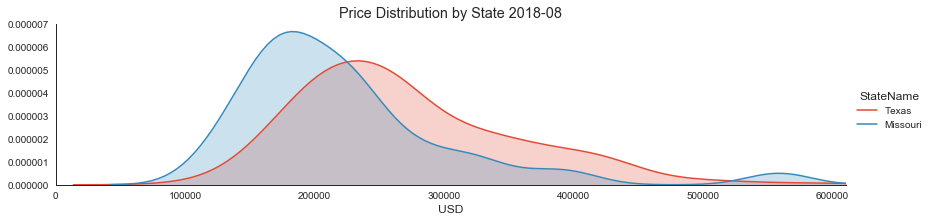

In [15]:
# Distribution of price, hue between Texas and Missouri
plot_distribution(df = price, var = 'MedianPrice', target = 'StateName')
plt.title("Price Distribution by State 2018-08")
plt.xlabel("USD")

Text(0,0.5,'Median Sale Price')

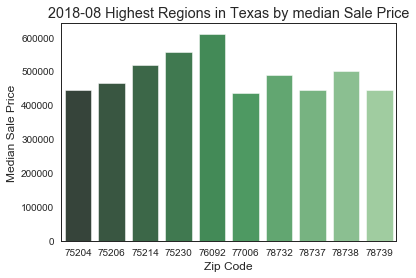

In [17]:
# Highest regions to live in Texas
tx_price_sort = price[price['StateName'] == 'Texas']
tx_price_sort.sort_values(by = ['MedianPrice'], ascending = False, inplace = True)
tx10 = tx_price_sort.iloc[:10]
plt.title("2018-08 Highest Regions in Texas by median Sale Price")
sns.barplot(x = 'RegionName', y = 'MedianPrice', data = tx10, palette="Greens_d")
plt.xlabel("Zip Code")
plt.ylabel("Median Sale Price")

Text(0,0.5,'Median Sale Price')

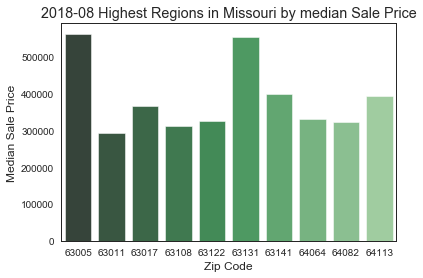

In [16]:
# Highest regions to live in Missouri
mo_price_sort = price[price['StateName'] == 'Missouri']
mo_price_sort.sort_values(by = ['MedianPrice'], ascending = False, inplace = True)
mo10 = mo_price_sort.iloc[:10]
plt.title("2018-08 Highest Regions in Missouri by median Sale Price")
sns.barplot(x = 'RegionName', y = 'MedianPrice', data = mo10, palette="Greens_d")
plt.xlabel("Zip Code")
plt.ylabel("Median Sale Price")

Text(0.5,20.8469,'USD')

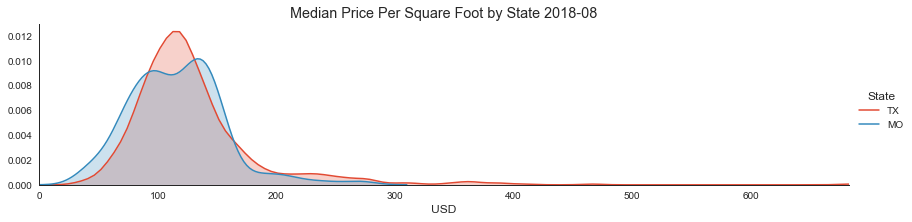

In [18]:
# Distribution of median square foot price, hue between Texas and Missouri
plot_distribution(df = med_sqft , var = 'MedianSqftPrice', target = 'State')
plt.title("Median Price Per Square Foot by State 2018-08")
plt.xlabel("USD")

Text(0.5,20.8469,'Days')

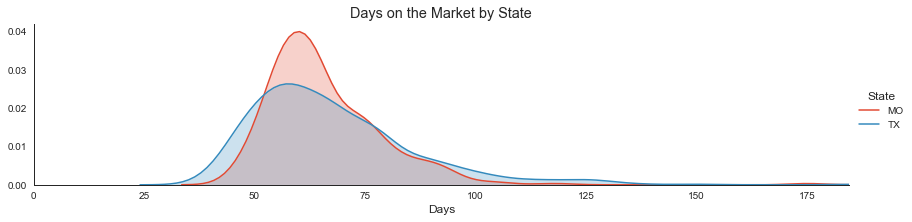

In [19]:
# Distribution of days on Market, hue between Texas and Missouri
plot_distribution(df = mkt_health_index , var = 'DaysOnMarket', target = 'State')
plt.title("Days on the Market by State")
plt.xlabel("Days")

Text(0,0.5,'Days on Market')

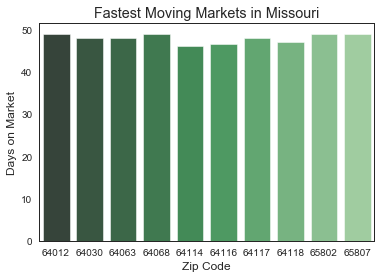

In [21]:
# Hottest markets in Missouri
mo_mkt = mkt_health_index[mkt_health_index['State'] == 'MO']
mo_mkt.sort_values(by = ['DaysOnMarket'], ascending = True, inplace = True)
mk10 = mo_mkt.iloc[:10]
plt.title("Fastest Moving Markets in Missouri")
sns.barplot(x = 'RegionName', y = 'DaysOnMarket', data = mk10, palette="Greens_d")
plt.xlabel("Zip Code")
plt.ylabel("Days on Market")

Text(0,0.5,'Days on Market')

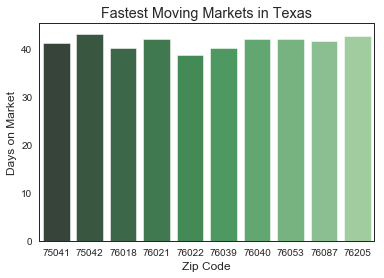

In [20]:
# Hottest markets in Texas
tx_mkt = mkt_health_index[mkt_health_index['State'] == 'TX']
tx_mkt.sort_values(by = ['DaysOnMarket'], ascending = True, inplace = True)
tx10 = tx_mkt.iloc[:10]
plt.title("Fastest Moving Markets in Texas")
sns.barplot(x = 'RegionName', y = 'DaysOnMarket', data = tx10, palette="Greens_d")
plt.xlabel("Zip Code")
plt.ylabel("Days on Market")

Text(0.5,20.8,'Price Reductions')

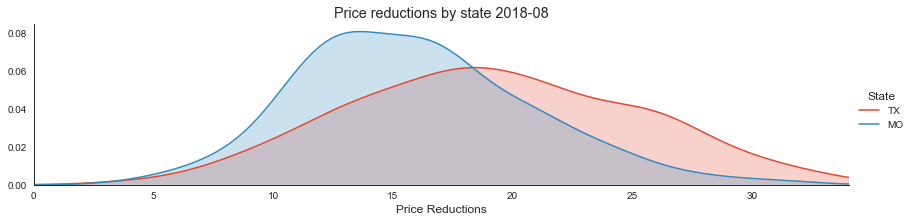

In [22]:
# % of listings with price reductions, hue between Texas and Missouri
plot_distribution(df = price_red , var = '%HomesPriceReduction', target = 'State')
plt.title("Price reductions by state 2018-08")
plt.xlabel("Price Reductions")

Text(0.5,20.8,'Price Increases')

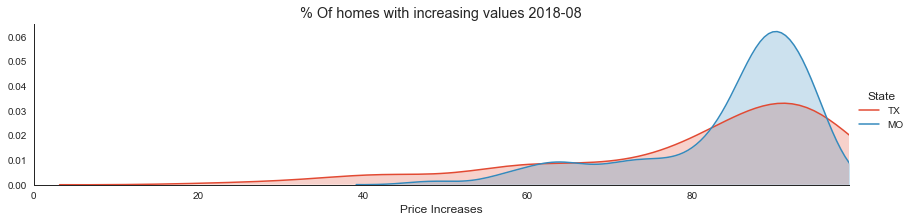

In [23]:
# % of homes with increasing values, hue between Texas and Missouri
plot_distribution(df = inc_val , var = '%HomesIncreasingValue', target = 'State')
plt.title("% Of homes with increasing values 2018-08")
plt.xlabel("Price Increases")

Text(0.5,20.8469,'Inventory')

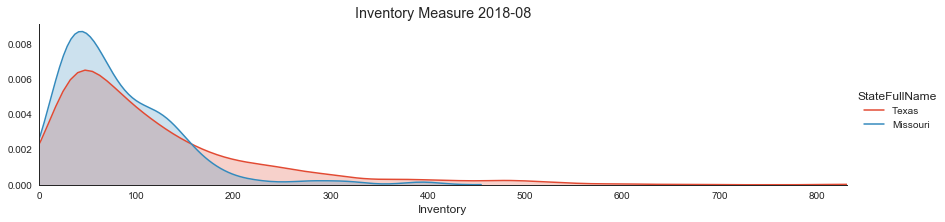

In [24]:
# Inventory measure, hue between Texas and Missouri
plot_distribution(df = inv_measure , var = 'Inventory', target = 'StateFullName')
plt.title("Inventory Measure 2018-08")
plt.xlabel("Inventory")

Text(0.5,20.8,'Market Health index')

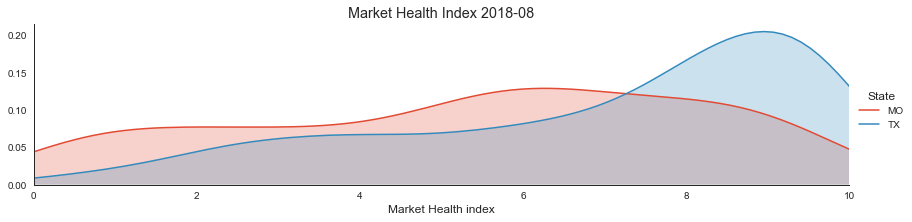

In [25]:
# Market Health index, hue between Texas and Missouri
plot_distribution(df = mkt_health_index , var = 'MarketHealthIndex', target = 'State')
plt.title("Market Health Index 2018-08")
plt.xlabel("Market Health index")

Text(0.5,20.8,'Buyer/Seller index')

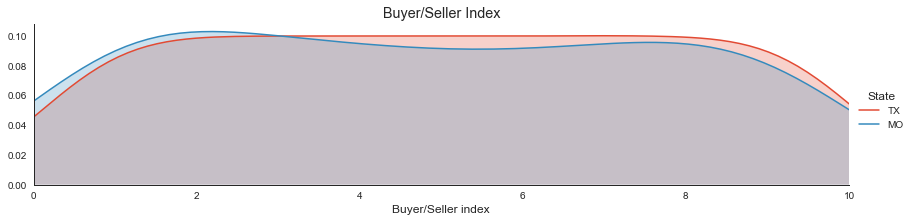

In [26]:
# Buyer/Seller index, hue between Texas and Missouri
plot_distribution(df = buyer_seller , var = 'BuyerSellerIndex', target = 'State')
plt.title("Buyer/Seller Index")
plt.xlabel("Buyer/Seller index")

Text(0.5,1,' % Price Cut Per Days On Market')

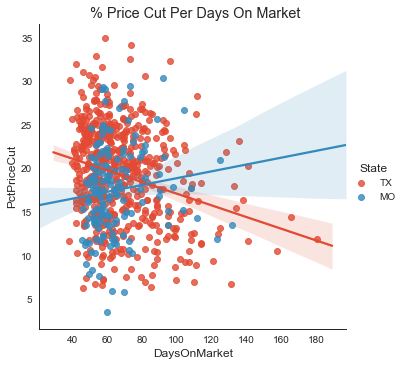

In [28]:
# Check linear regression to see fit line on Price Cut as a function of Days on Market
sns.lmplot(x='DaysOnMarket', y='PctPriceCut', data=buyer_seller, hue = 'State')
plt.title(" % Price Cut Per Days On Market")

Text(0.5,20.8469,'Monthly Turnover')

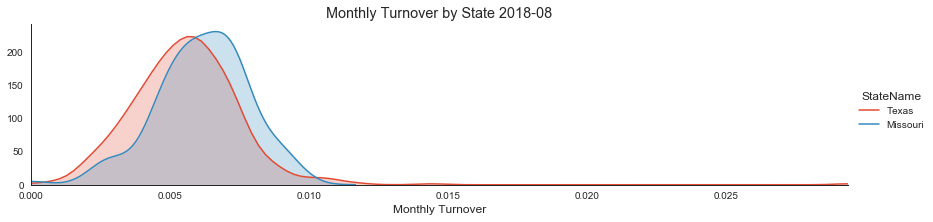

In [27]:
# Monthly Turnover, hue between Texas and Missouri
plot_distribution(df = mon_turnover, var = 'MonthlyTurnover', target = 'StateName')
plt.title("Monthly Turnover by State 2018-08")
plt.xlabel("Monthly Turnover")

In [29]:
# List all Dataframes to merge later
#zillow = [price, med_sqft, mkt_health_index, inv_measure, buyer_seller, mon_turnover, inc_val, price_red]

In [ ]:
zillow = pd.merge(left = price, right = med_sqft, on = 'RegionName')

In [30]:
zillow = pd.merge(left = zillow, right = mkt_health_index, on ='RegionName')

NameError: name 'zillow' is not defined

In [ ]:
zillow = pd.merge(left = zillow, right = inv_measure, on = 'RegionName')

In [ ]:
zillow = pd.merge(left = zillow, right = buyer_seller, on = 'RegionName')

In [ ]:
zillow = pd.merge(left = zillow, right = mon_turnover, on = 'RegionName')

In [ ]:
zillow = pd.merge( left = zillow, right = inc_val, on = 'RegionName')

In [ ]:
zillow = pd.merge(left = zillow, right = price_red, on = 'RegionName')

In [ ]:
# Look at the resulting merged dataframe
zillow

In [ ]:
zillow.drop(columns = ['State_x','State_y','Metro_y','SizeRank_x','RegionType','City_x',
                       'CountyName_y','Metro_x','StateFullName','DataTypeDescription','State_x',
                       'CBSA Title','RegionID_y','StateName_y','RegionID_x','City_y','State_y',
                       'Metro_y','CountyName','SizeRank_x','RegionID_y','StateName_x','CountyName_x',
                      'SizeRank_y','DaysOnMarket_y', 'CBSATitle','SizeRankCity','SizeRankMetro', 'StockOfREOs' ],
            inplace = True)

In [ ]:
zillow

In [ ]:
cols = list(zillow.columns.values)
cols

In [ ]:
zillow = zillow[['State','County','City','Metro','RegionName','MedianPrice','MedianSqftPrice','MarketHealthIndex',
                'SellForGain','PrevForeclosed','ForeclosureRatio','ZHVI','MoM','YoY','ForecastYoYPctChange',
                'StockOfREOs','NegativeEquity','Delinquency','DaysOnMarket_x','Inventory', 'PctPriceCut', 'BuyerSellerIndex',
                'BuyerSellerIndexMetro', 'MonthlyTurnover', '%HomesIncreasingValue', '%HomesPriceReduction']]

In [ ]:
zillow.rename(columns = {'DaysOnMarket_x': 'DaysOnMarket'}, inplace = True)

In [ ]:
# Check for missing values
zillow.isnull().sum()

In [ ]:
zillow